# Data Loading

In [1]:
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_path = "../data/input/train.jsonl"

In [3]:
# Data loading

myData = pd.read_json(train_path, lines=True)
analysisData = myData[["postText", "targetParagraphs", "targetTitle", "targetDescription", "spoiler", "tags"]]
for c in ["postText", "targetParagraphs", "tags", "spoiler"]:
    analysisData[c] = analysisData[c].apply(lambda l: " ".join(l))

/tmp/ipykernel_6738/1243886341.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysisData[c] = analysisData[c].apply(lambda l: " ".join(l))
/tmp/ipykernel_6738/1243886341.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysisData[c] = analysisData[c].apply(lambda l: " ".join(l))
/tmp/ipykernel_6738/1243886341.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

# Type distribution

In [4]:
# Plot to display number of training samples per type

def plot_col_per_tag(title: str, myData: pd.DataFrame, show_mean: bool = True):
    fig, fig2 = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
    fig.tight_layout(pad=6.0)
    fig.suptitle(title, fontsize=16)
    fig2 = fig2.flat
    for column, myfigure in zip(myData.columns, fig2):
        if column != "tags":
            for tag in myData.tags.unique():
                x = sorted(myData[myData["tags"]==tag][column].values)
                y = np.arange(len(x))
                myfigure.plot(x,y, label=tag)
                if show_mean:
                    myfigure.axvline(x=np.nanmean(x), color="black", linestyle=":")
            myfigure.legend()
            myfigure.set_title(column)
            myfigure.set_xlabel("Length")
            myfigure.set_ylabel("Spoiler")
    plt.show()

<Axes: xlabel='tags'>

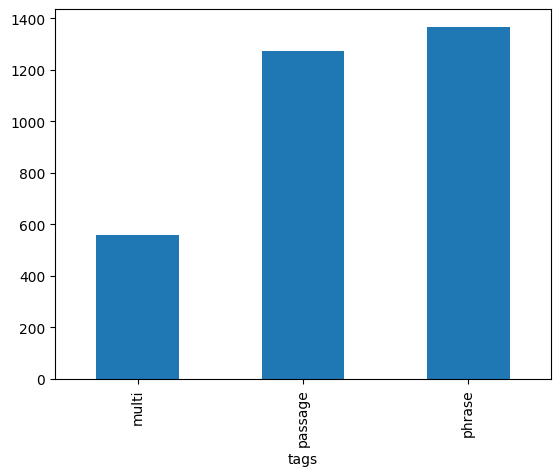

In [5]:
# Number of training samples per type
analysisData.groupby("tags")["spoiler"].count().plot(kind="bar")

In [6]:
analysisData.groupby("tags")["spoiler"].count()

tags
multi       559
passage    1274
phrase     1367
Name: spoiler, dtype: int64

# Char Length

In [7]:
char_lengths = analysisData.loc[:, analysisData.columns != 'tags'].applymap(lambda text: len(text) if text else 0)
char_lengths["tags"] = analysisData["tags"]

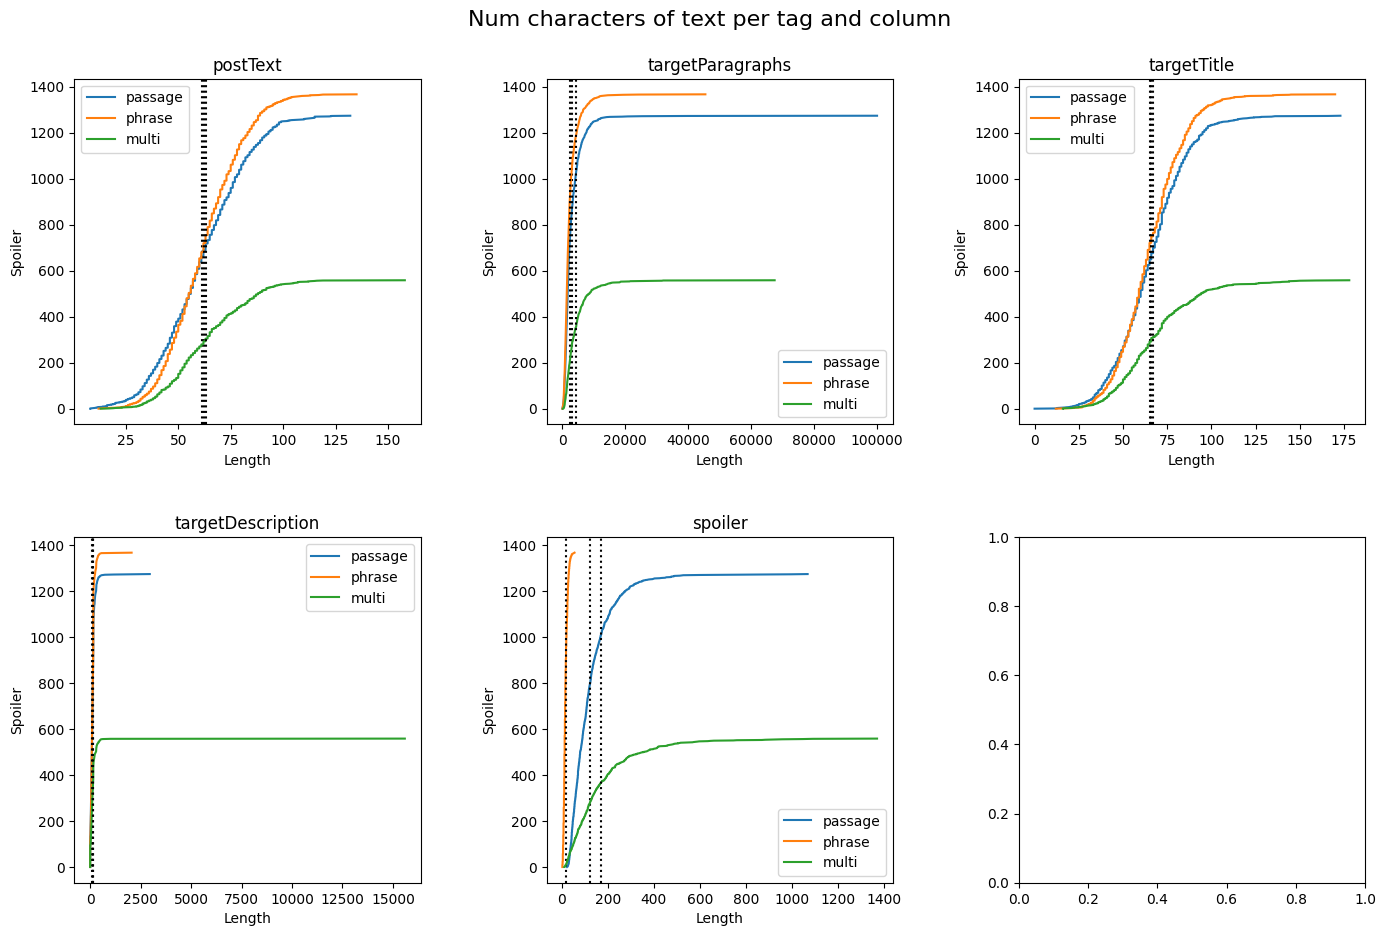

In [8]:
plot_col_per_tag(title="Num characters of text per tag and column", myData=char_lengths, show_mean=True)

# Token Length

In [9]:
token_lengths = analysisData.loc[:, analysisData.columns != 'tags'].applymap(lambda text: len(text.split(" ")) if text else 0)
token_lengths["tags"] = analysisData["tags"]

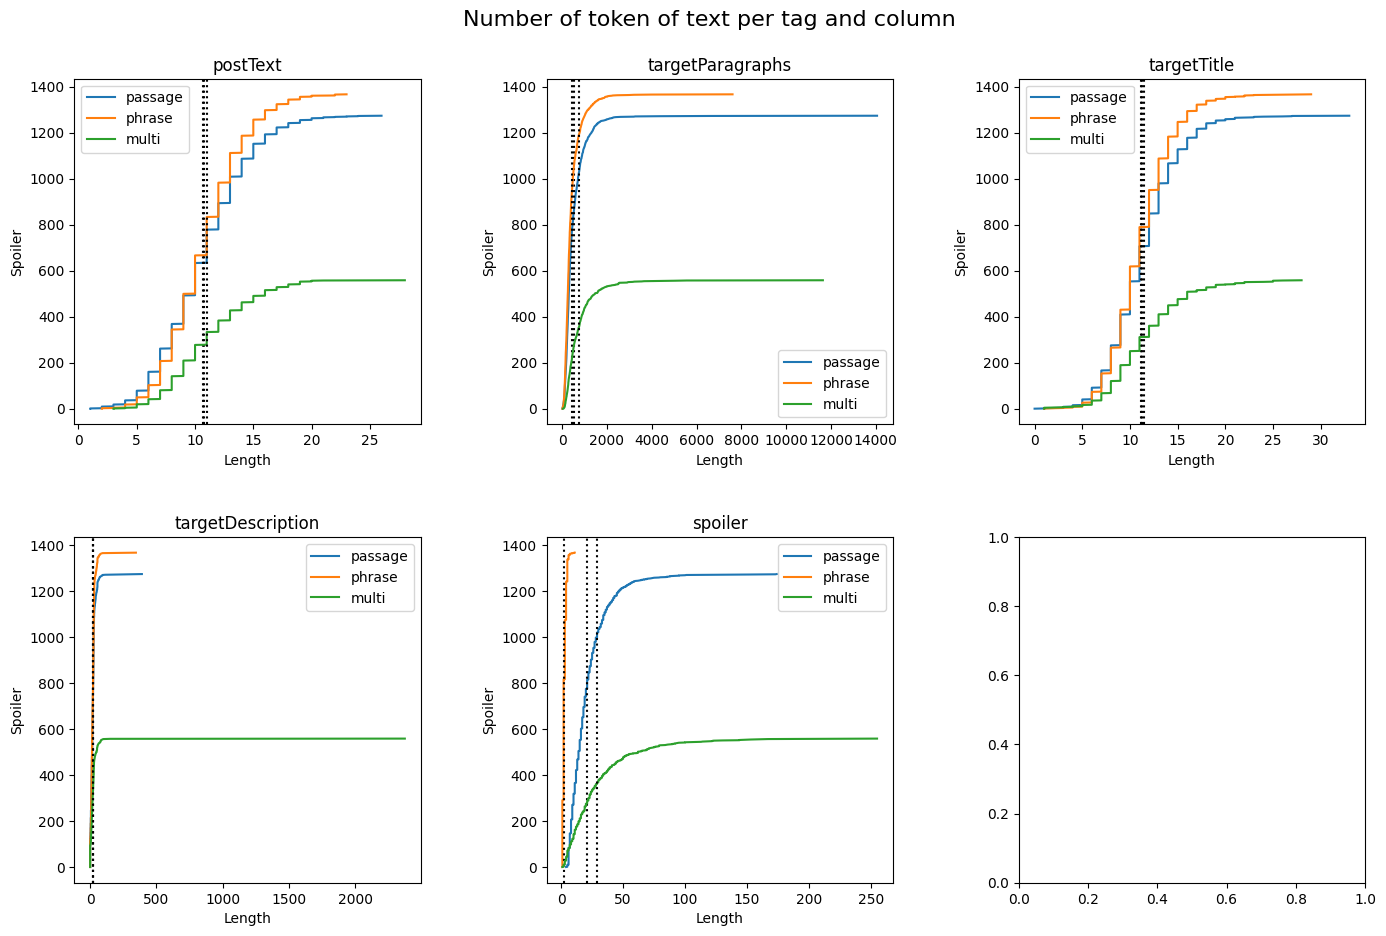

In [10]:
plot_col_per_tag(title="Number of token of text per tag and column", myData=token_lengths, show_mean=True)

# Number of numbers in general

In [25]:
num_lengths = analysisData.loc[:, analysisData.columns != 'tags'].applymap(lambda text: len(re.findall(r"\d+", str(text))) if text else 0)
num_lengths["tags"] = analysisData["tags"]

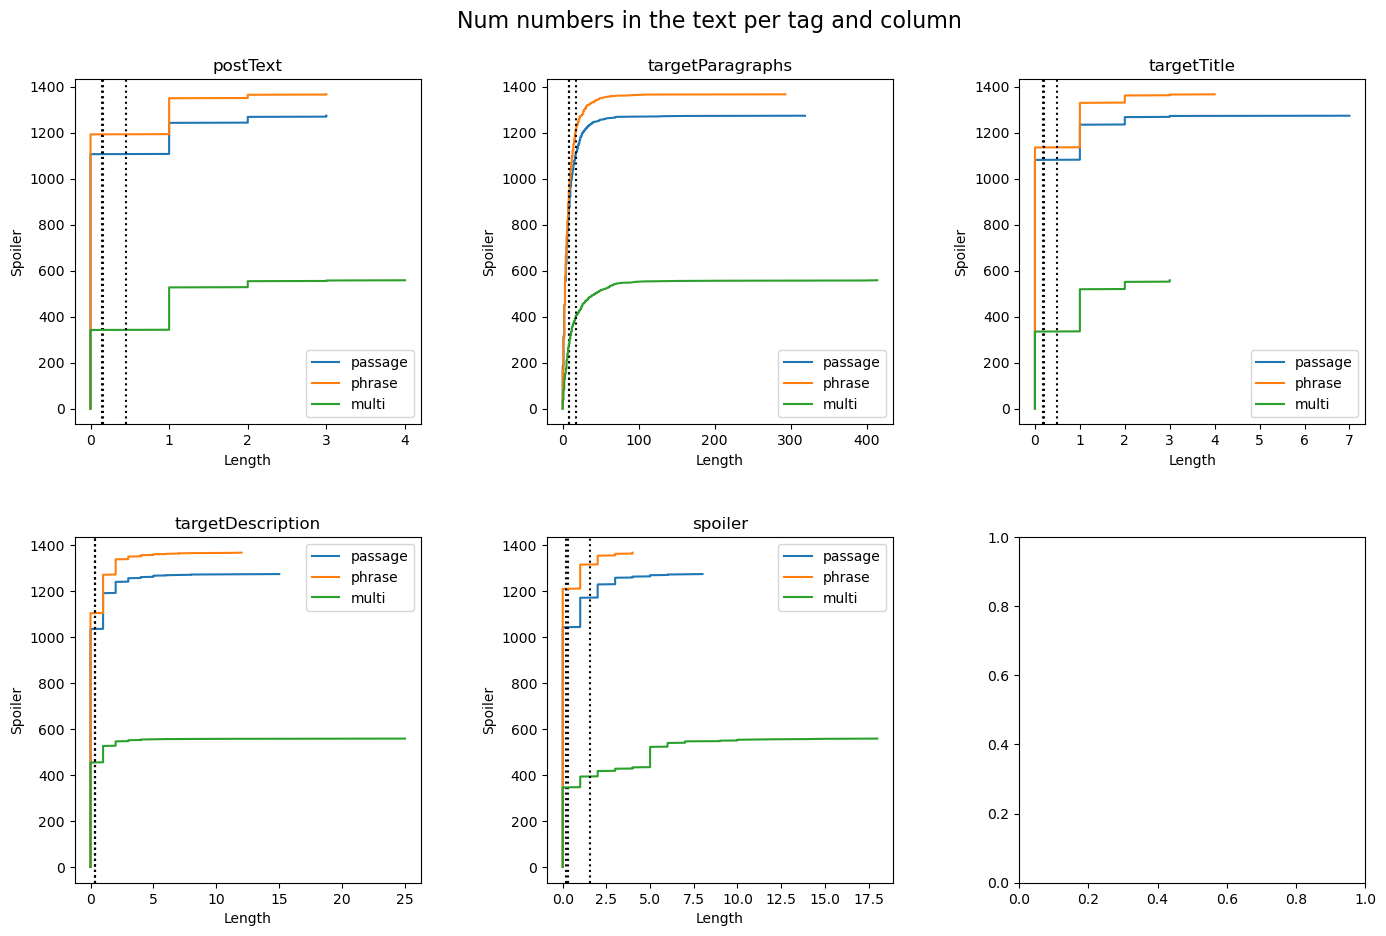

In [26]:
plot_col_per_tag(title="Num numbers in the text per tag and column", myData=num_lengths, show_mean=True)

# Table for reading


In [11]:
short = analysisData[["postText", "spoiler", "tags"]]
short

,postText,spoiler,tags
0,"Wes Welker Wanted Dinner With Tom Brady, But P...",how about that morning we go throw?,passage
1,NASA sets date for full recovery of ozone hole,2070,phrase
2,This is what makes employees happy -- and it's...,intellectual stimulation,phrase
3,Passion is overrated — 7 work habits you need ...,Purpose connects us to something bigger and in...,multi
4,The perfect way to cook rice so that it's perf...,in a rice cooker,phrase
...,...,...,...
3195,Has Facebook's video explosion completely shak...,it hasn’t necessarily taken the wind out of Yo...,passage
3196,Cop Is Eating At A Chili's When Teen Hands Him...,"It read, ""Thanks for keeping us safe.""",passage
3197,5 popular myths about visible signs of aging t...,1. Anti-wrinkle creams will erase the fine lin...,multi
3198,You need to see this Twitter account that pred...,@beyoncefan666,phrase


# URLs and sources

In [12]:
source = myData[["targetUrl", "tags"]]

In [13]:
def match(url):
    if url:
        url = re.findall(r"(?<=://)(.*?)(?=/)", url)[0] if re.findall(r"(?<=://)(.*?)(?=/)", url) else ""
        if url.startswith("www."):
            url = url[4:]
        return url

<Axes: xlabel='targetUrl'>

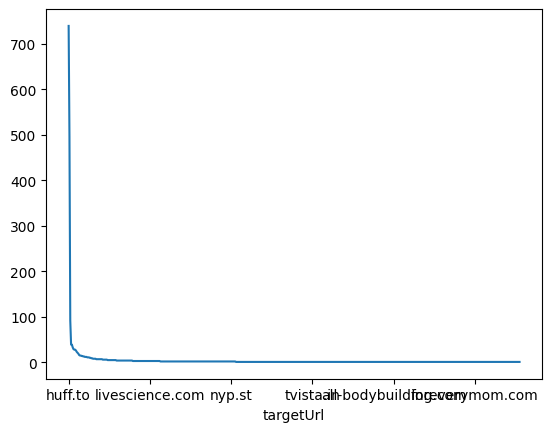

In [14]:
# Distribution of domainnames in the targetUrl
source["targetUrl"].apply(match).value_counts().plot()

In [15]:
# Unique domains
unique_sites = source["targetUrl"].apply(match).unique()
len(unique_sites)

557

In [16]:
source["domain"] = source["targetUrl"].apply(match)

/tmp/ipykernel_6738/3509893551.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source["domain"] = source["targetUrl"].apply(match)


<Axes: xlabel='domain'>

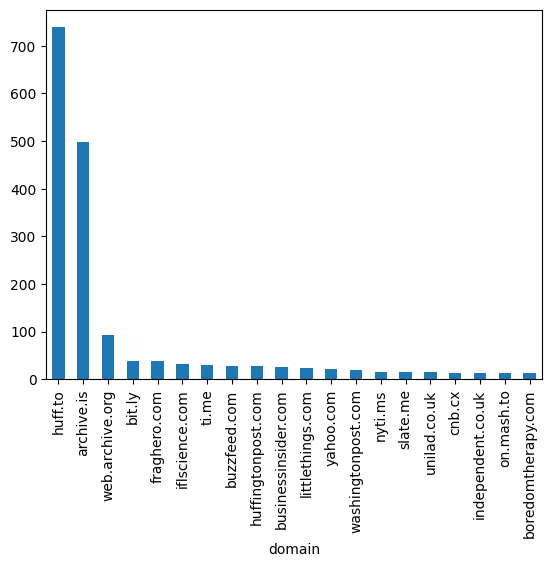

In [17]:
# Most articles come from huff.to followed by archive.is which is an archiving service.
# This could be further resolved.
source.groupby("domain")["tags"].count().sort_values(ascending=False).head(20).plot(kind="bar")

# Passage

In [18]:
analysisData["tags_clean"]=analysisData["tags"].explode()

/tmp/ipykernel_6738/1593526322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysisData["tags_clean"]=analysisData["tags"].explode()


In [19]:
passage = analysisData[analysisData["tags_clean"]=="passage"][["targetParagraphs", "spoiler"]].explode("targetParagraphs").explode("spoiler")

In [20]:
passage[passage["targetParagraphs"]==passage["spoiler"]]

,targetParagraphs,spoiler
2191,Protests took place around the world to mark I...,Protests took place around the world to mark I...
2333,"Coworkers helped Chris Veseth, who was born wi...","Coworkers helped Chris Veseth, who was born wi..."
2376,Once you realize that the legs aren't shiny & ...,Once you realize that the legs aren't shiny & ...


In [21]:
analysisData
analysisData["tags_clean"].groupby(analysisData["tags_clean"]).count()

tags_clean
multi       559
passage    1274
phrase     1367
Name: tags_clean, dtype: int64